<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/chapter-5/chapter_5_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting helper function

In [27]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_dataset(X, y):
  cmap_bold = ["darkorange", "darkblue"]
  markers = {1: "X", 0: "v"}
  sns.scatterplot(
      x=X[:, 0],
      y=X[:, 1],
      hue=y,
      palette=cmap_bold,
      alpha=1.0,
      edgecolor="black",
      style=y, markers=markers
  )
  
def plot_decision_boundary(X, y, clf, clf_name):
  _, ax = plt.subplots()
  cmap_light = ListedColormap(["orange", "white"])
  disp = DecisionBoundaryDisplay.from_estimator(
      clf,
      X,
      cmap=cmap_light,
      ax=ax,
      response_method="predict",
      alpha=0.5,
      xlabel='feature_1',
      ylabel='feature_2',
  )
  disp.plot(plot_method="contour", cmap="gist_gray", ax = ax, alpha = 1.)
  # Plot also the training points
  plot_dataset(X, y)
  plt.title("2-Class classification using %s classifier" %clf_name)


# from: https://imbalanced-learn.org/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py
def plot_decision_function(X, y, clf, ax):
  """Plot the decision function of the classifier and the original data"""
  plot_step = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
  )

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, alpha=0.4)
  ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
  ax.set_title(f"Resampling using {clf[0].__class__.__name__}")

# Create dataset

y_train:  Counter({0: 39404, 1: 596})
y_test:  Counter({0: 9851, 1: 149})


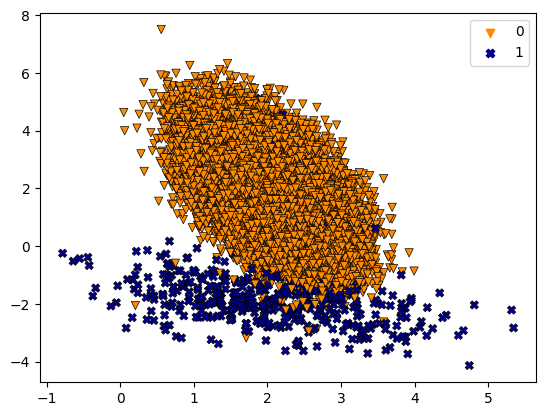

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.datasets import fetch_datasets
import pandas as pd
from collections import Counter

X, y = make_classification(n_samples=50000,
                      n_features=2,
                      n_redundant=0,
                      n_clusters_per_class=1,
                      weights=[0.99],
                      class_sep=2,# how separate the classes are
                      random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

print('y_train: ', Counter(y_train))
print('y_test: ', Counter(y_test))

plot_dataset(X_train, y_train)




In [30]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.base import clone

class MetaCost:
    """
    +-----------------+--------------+--------------+
    |                 |         Actual class        |
    + Predicted Class +--------------+--------------+
    |                 | class0       | class1       |
    +-----------------+--------------+--------------+
    | h(x) = class0   |      0       |      a       |
    | h(x) = class1   |      c       |      0       |
    +-----------------+--------------+--------------+
    | C = np.array([[0, a],[c, 0]])                 |
    +-----------------------------------------------+

    """
    def __init__(self, classifier, cost_matrix, resamples=10, fraction=1, num_class=2):
        self.classifier = classifier
        self.cost_matrix = cost_matrix
        self.resamples = resamples
        self.fraction = fraction
        self.num_classes = num_class

    def fit(self, X, y):
        # Combine the features and the target into one DataFrame
        data = pd.DataFrame(data=X)
        data['target'] = y

        # Calculate the number of samples in each resample
        num_samples = len(data) * self.fraction
        
        # Resample the data, train a model on each resample, and store the models
        models = [self._train_on_resample(data.sample(n=int(num_samples), replace=True)) for _ in range(self.resamples)]

        # Relabel the instances based on the models' predictions and the cost matrix
        new_labels = self._relabel_instances(data, models)

        # Train a new model on the data with relabeled instances
        final_model = clone(self.classifier)
        final_model.fit(data.drop(columns=['target']).values, new_labels)
        
        self.model = final_model
        self.__class__ = self.model.__class__
        self.__dict__ = self.model.__dict__
        return final_model

    def _train_on_resample(self, resample):
        X_resampled = resample.drop(columns=['target']).values
        y_resampled = resample['target'].values
        model = clone(self.classifier)
        return model.fit(X_resampled, y_resampled)

    def _relabel_instances(self, data, models):
        X_array = data.drop(columns=['target']).values
        labels = []
        for i in range(len(data)):
            class_probs = [self._get_class_probs(model, X_array[[i]]) for model in models]
            average_probs = np.mean(class_probs, 0).T
            labels.append(self._get_new_label(average_probs))
        return labels

    def _get_class_probs(self, model, instance):
        return model.predict_proba(instance)

    def _get_new_label(self, average_probs):
        # Multiply the cost matrix with the average probabilities.
        # This gives us the expected costs for each class.
        costs = self.cost_matrix.dot(average_probs)

        # Find the class with the minimum expected cost.
        # This is the new label for the instance.
        return np.argmin(costs)

In [31]:
from sklearn.metrics import f1_score

def compute_f1_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# LogisticRegression with and without class weight implementation + MetaCost here 
## plot decision function and PR curves comparison


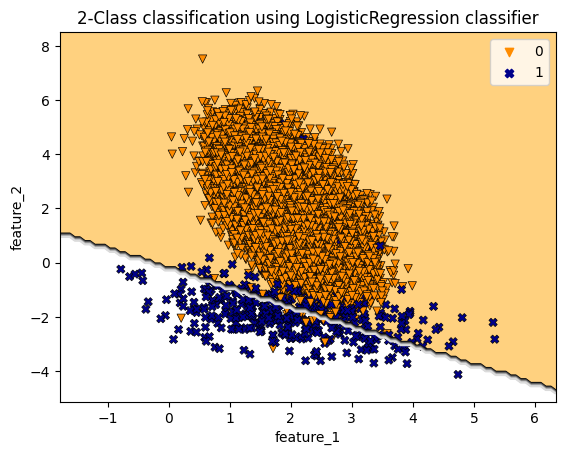

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.40      1.00      0.63      0.42      9851
    class 1       1.00      0.40      1.00      0.57      0.63      0.37       149

avg / total       0.99      0.99      0.40      0.99      0.63      0.42     10000



0.5673076923076923

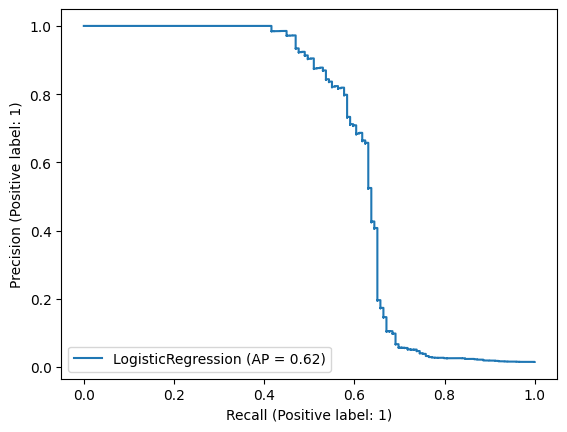

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from imblearn.metrics import classification_report_imbalanced

lr = LogisticRegression(random_state=0, max_iter=150).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, lr, 'LogisticRegression')
plt.show()

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, ax = plt.gca(),name = "LogisticRegression")

print(classification_report_imbalanced(y_test, lr.predict(X_test), target_names=['class 0', 'class 1']))
     
compute_f1_score(lr, X_test, y_test)     

In [ ]:
from sklearn.metrics import average_precision_score, confusion_matrix

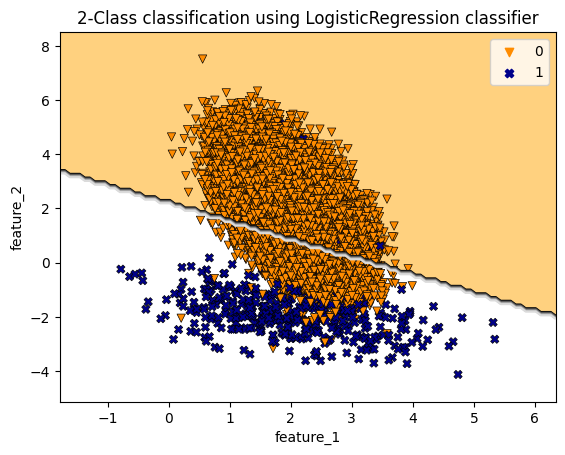

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      0.87      0.69      0.93      0.78      0.61      9851
    class 1       0.07      0.69      0.87      0.13      0.78      0.59       149

avg / total       0.98      0.87      0.69      0.92      0.78      0.61     10000



0.13472858077174626

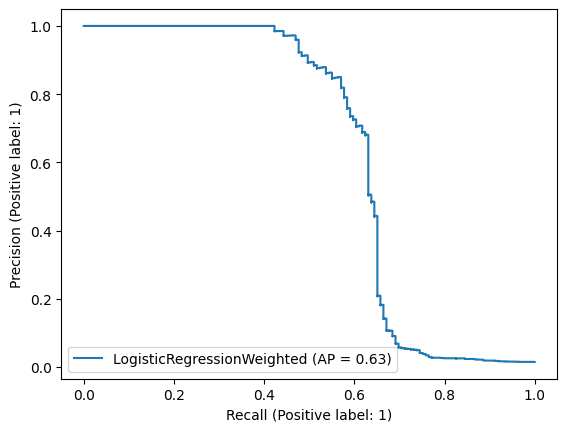

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay

lr_weighted = LogisticRegression(class_weight='balanced', random_state=0, max_iter=150).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, lr_weighted, 'LogisticRegression')
plt.show()

PrecisionRecallDisplay.from_estimator(lr_weighted, X_test, y_test, ax = plt.gca(),name = "LogisticRegressionWeighted")

print(classification_report_imbalanced(y_test, lr_weighted.predict(X_test), target_names=['class 0', 'class 1']))
compute_f1_score(lr_weighted, X_test, y_test)     

The class weighting technique produces pretty much the same average precision but worse f1 score. Let's try to tune the class_weights parameter using grid search that optimizes our f1 score. 
We can always try to optimize any other objective like average precision, or precision or recall etc. 


In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in np.linspace(0.05, 0.95, 20)]}

# Instantiate the grid search model
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'class_weight': {0: 0.14473684210526316, 1: 0.8552631578947368}}

# testing LR with class weight = {0: 0.14473684210526316, 1: 0.8552631578947368}}


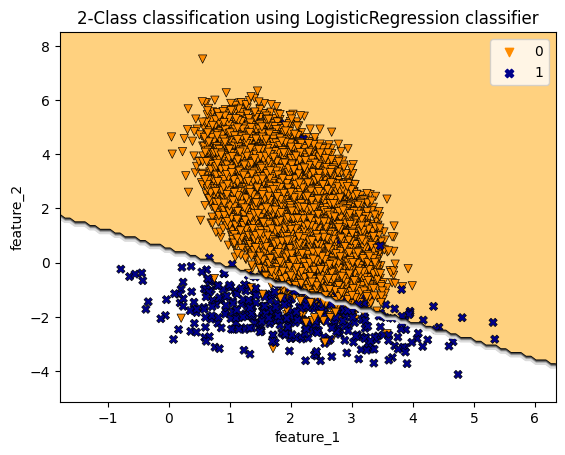

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.58      1.00      0.76      0.61      9851
    class 1       0.79      0.58      1.00      0.67      0.76      0.56       149

avg / total       0.99      0.99      0.59      0.99      0.76      0.61     10000



0.6718146718146718

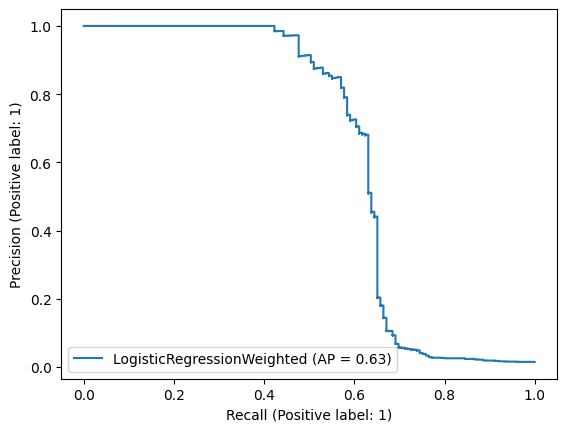

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay

lr_weighted = LogisticRegression(class_weight ={0: 0.14473684210526316, 1: 0.8552631578947368}, random_state=0, max_iter=150).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, lr_weighted, 'LogisticRegression')
plt.show()

PrecisionRecallDisplay.from_estimator(lr_weighted, X_test, y_test, ax = plt.gca(),name = "LogisticRegressionWeighted")

print(classification_report_imbalanced(y_test, lr_weighted.predict(X_test), target_names=['class 0', 'class 1']))
compute_f1_score(lr_weighted, X_test, y_test)     

In [ ]:
print("train set distribution:")
print(Counter(y_train))
X_test_resampled = np.concatenate((X_test[np.where(y_test==0)[0][:320]], X_test[np.where(y_test==1)[0]]))
y_test_resampled = np.concatenate((y_test[np.where(y_test==0)[0][:320]], y_test[np.where(y_test==1)[0]]))
print("test set distribution:")
print(Counter(y_test_resampled))

y_pred_resampled = lr_weighted.predict(X_test_resampled)
compute_f1_score(lr_weighted, X_test_resampled, y_test_resampled)  

print("\nConfusion Matrix for LR(class_weight = balanced) trained on imbalanced dataset and tested on relatively balanced dataset")
print(confusion_matrix(y_test_resampled, y_pred_resampled))
print("f1-score: %.4f"%(compute_f1_score(lr_weighted, X_test_resampled, y_test_resampled) ))
y_pred_resampled = lr_weighted.predict(X_test_resampled)
y_pred_resampled_prob = lr_weighted.predict_proba(X_test_resampled)[:,1]
print("AP score: %.4f"%(average_precision_score(y_test_resampled, y_pred_resampled_prob) ))

y_pred_resampled = lr.predict(X_test_resampled)
y_pred_resampled_prob = lr.predict_proba(X_test_resampled)[:,1]
print("\nConfusion Matrix for LR(class_weight = None) trained on imbalanced dataset and tested on relatively balanced dataset")
print(confusion_matrix(y_test_resampled, y_pred_resampled))
print("f1-score: %.4f"%(compute_f1_score(lr, X_test_resampled, y_test_resampled) ))
print("AP score: %.4f"%(average_precision_score(y_test_resampled, y_pred_resampled_prob) ))

train set distribution:
Counter({0: 39404, 1: 596})
test set distribution:
Counter({0: 320, 1: 149})

Confusion Matrix for LR(class_weight = balanced) trained on imbalanced dataset and tested on relatively balanced dataset
[[320   0]
 [ 62  87]]
f1-score: 0.7373
AP score: 0.8166

Confusion Matrix for LR(class_weight = None) trained on imbalanced dataset and tested on relatively balanced dataset
[[320   0]
 [ 90  59]]
f1-score: 0.5673
AP score: 0.8164


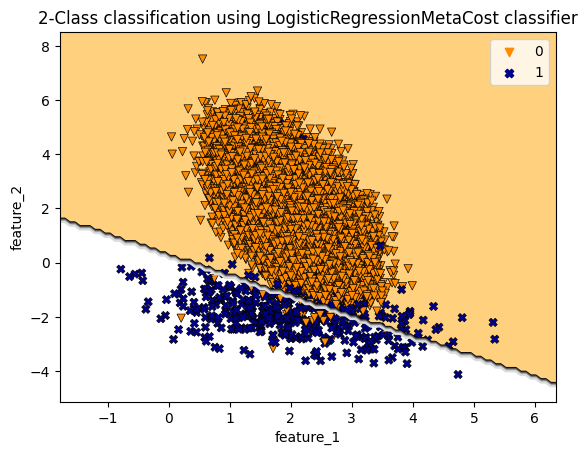

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.49      1.00      0.70      0.51      9851
    class 1       0.92      0.49      1.00      0.64      0.70      0.46       149

avg / total       0.99      0.99      0.50      0.99      0.70      0.51     10000



0.6403508771929824

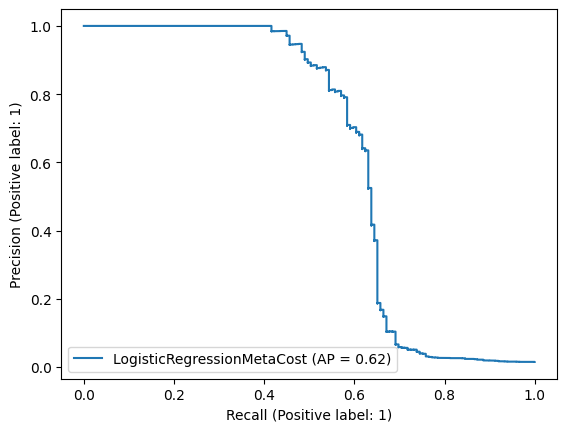

In [35]:
C = np.array([[0, 99], [50, 0]])

logisticRegressionMetaCost = MetaCost(LogisticRegression(random_state=0, max_iter=150), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, logisticRegressionMetaCost, 'LogisticRegressionMetaCost')
plt.show()

PrecisionRecallDisplay.from_estimator(logisticRegressionMetaCost, X_test, y_test, ax = plt.gca(),name = "LogisticRegressionMetaCost")    

print(classification_report_imbalanced(y_test, logisticRegressionMetaCost.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(logisticRegressionMetaCost, X_test, y_test)

# Random Forest with and without class weight + MetaCost implementation here
## plot decision functions and PR curves comparison

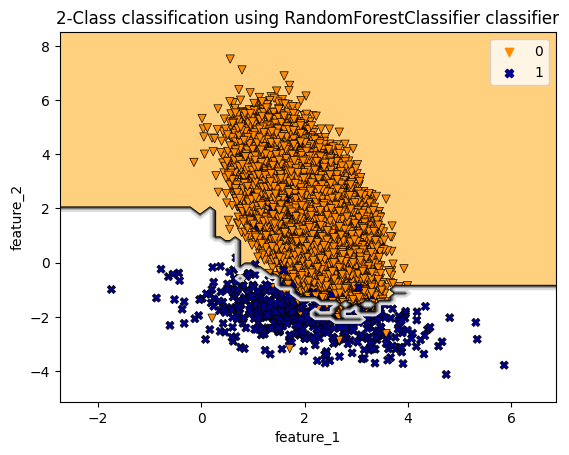

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.40      1.00      0.63      0.42      9851
    class 1       1.00      0.40      1.00      0.57      0.63      0.37       149

avg / total       0.99      0.99      0.40      0.99      0.63      0.42     10000



0.6942148760330578

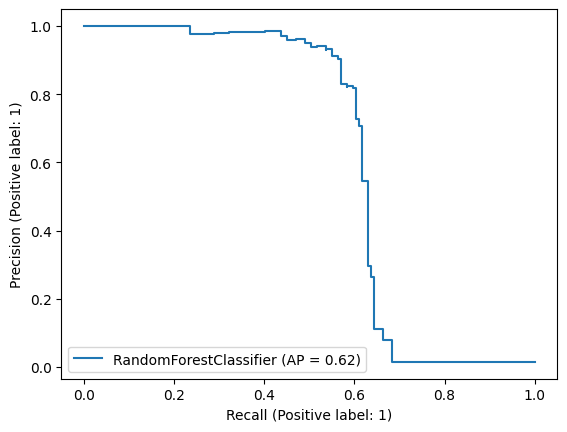

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay

RF_clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'RandomForestClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "RandomForestClassifier")

print(classification_report_imbalanced(y_test, lr.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)     

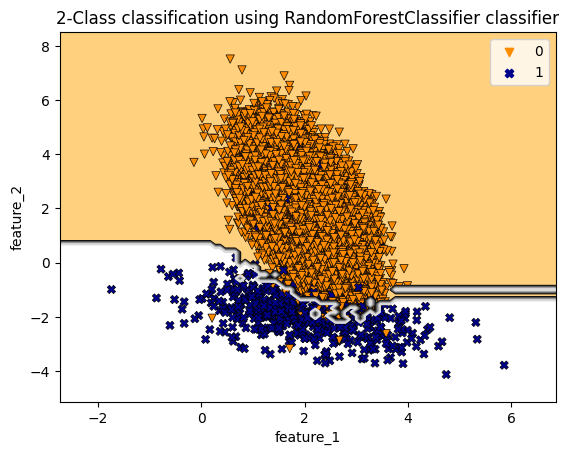

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.40      1.00      0.63      0.42      9851
    class 1       1.00      0.40      1.00      0.57      0.63      0.37       149

avg / total       0.99      0.99      0.40      0.99      0.63      0.42     10000



0.7024793388429752

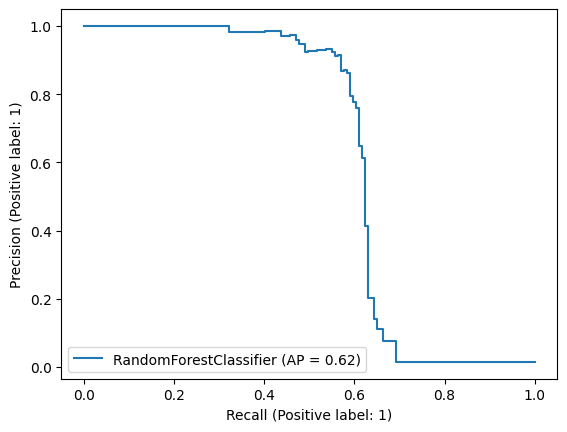

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay

RF_clf = RandomForestClassifier(class_weight="balanced", random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'RandomForestClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "RandomForestClassifier")

print(classification_report_imbalanced(y_test, lr.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)     

# tuned weights


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Define the parameter grid
# param_grid = {'scale_pos_weight': [x for x in np.linspace(90, 120, 20)]}
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in np.linspace(0.05, 0.95, 20)]}

# Instantiate the grid search model
# baseline best: f1: 0.7049180327868854, aur-pr=0.63
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'class_weight': {0: 0.09736842105263158, 1: 0.9026315789473685}}

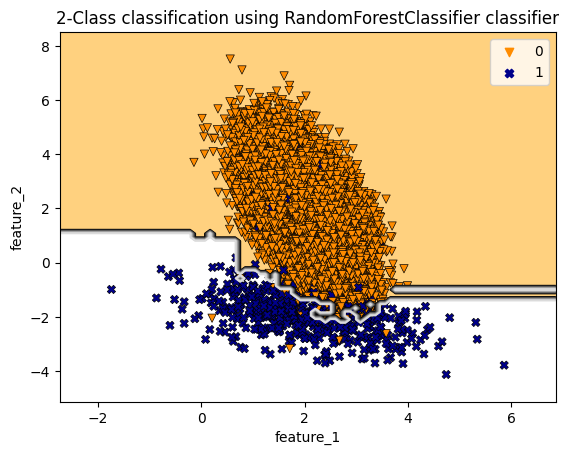

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.56      1.00      0.75      0.59      9851
    class 1       0.91      0.56      1.00      0.70      0.75      0.54       149

avg / total       0.99      0.99      0.57      0.99      0.75      0.59     10000



0.6970954356846473

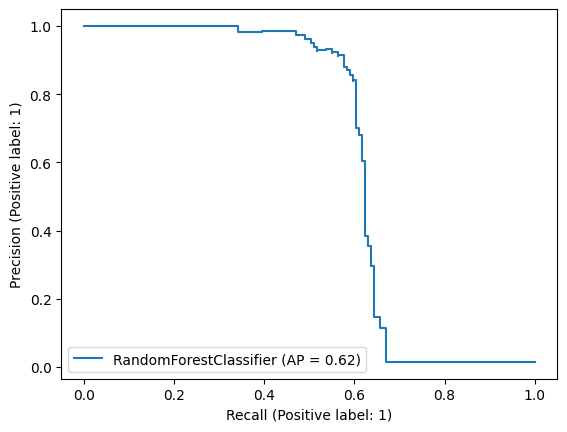

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay

RF_clf = RandomForestClassifier(class_weight={0: 0.09736842105263158, 1: 0.9026315789473685}, random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'RandomForestClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "RandomForestClassifier")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)     

## metacost random forest

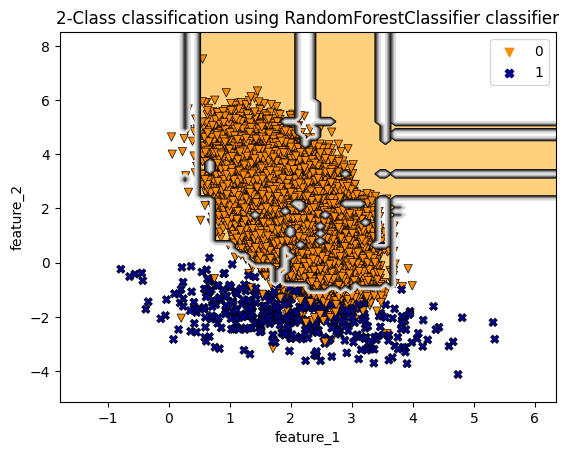

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      0.97      0.64      0.98      0.79      0.64      9851
    class 1       0.23      0.64      0.97      0.34      0.79      0.60       149

avg / total       0.98      0.96      0.65      0.97      0.79      0.64     10000

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      0.97      0.64      0.98      0.79      0.64      9851
    class 1       0.23      0.64      0.97      0.34      0.79      0.60       149

avg / total       0.98      0.96      0.65      0.97      0.79      0.64     10000



0.3380281690140845

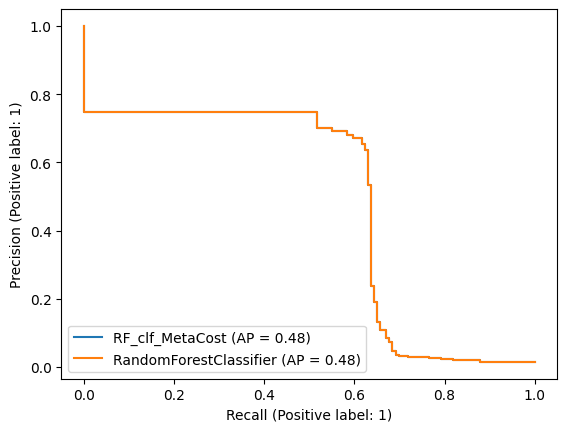

In [ ]:
C = np.array([[0, 100], [1, 0]])

RF_clf_MetaCost = MetaCost(RandomForestClassifier(random_state=0), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, RF_clf_MetaCost, 'RandomForestClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf_MetaCost, X_test, y_test, ax = plt.gca(),name = "RF_clf_MetaCost")    

print(classification_report_imbalanced(y_test, RF_clf_MetaCost.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf_MetaCost, X_test, y_test)     


PrecisionRecallDisplay.from_estimator(RF_clf_MetaCost, X_test, y_test, ax = plt.gca(),name = "RandomForestClassifier")

print(classification_report_imbalanced(y_test, RF_clf_MetaCost.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf_MetaCost, X_test, y_test)     

# XGBoost with and without class weight + MetaCost implementation here 
## plot decision function and PR curves comparison


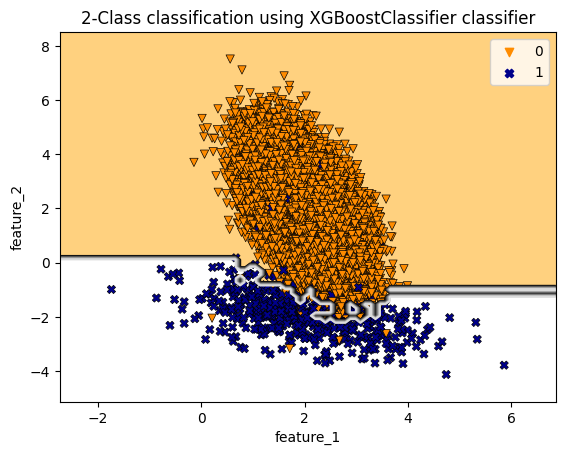

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.58      1.00      0.76      0.60      9851
    class 1       0.91      0.58      1.00      0.70      0.76      0.55       149

avg / total       0.99      0.99      0.58      0.99      0.76      0.60     10000



0.7049180327868854

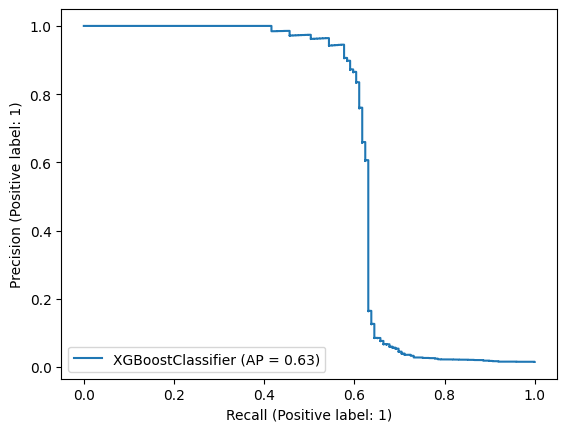

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay
from xgboost import XGBClassifier

RF_clf = XGBClassifier(random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'XGBoostClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "XGBoostClassifier")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))


compute_f1_score(RF_clf, X_test, y_test)     

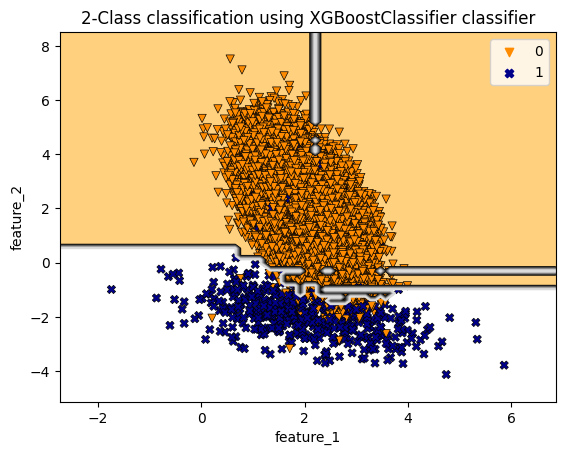

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      0.99      0.62      0.99      0.79      0.64      9851
    class 1       0.43      0.62      0.99      0.51      0.79      0.59       149

avg / total       0.99      0.98      0.63      0.98      0.79      0.64     10000



0.510989010989011

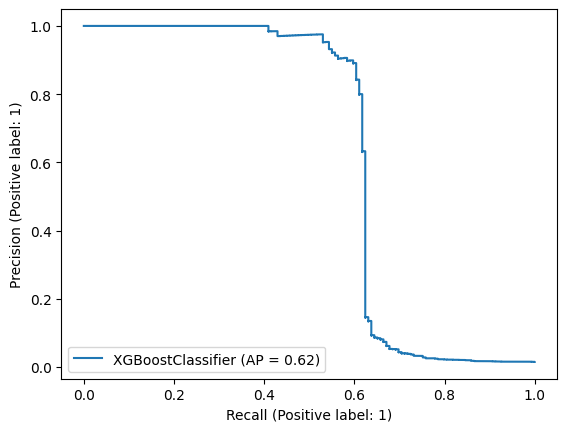

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay
from xgboost import XGBClassifier

RF_clf = XGBClassifier(scale_pos_weight=99, random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'XGBoostClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "XGBoostClassifier")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)     

# with tuned class_Weights

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Define the parameter grid
param_grid = {'scale_pos_weight': [x for x in np.linspace(90, 120, 20)]}

# Instantiate the grid search model
# baseline best: f1: 0.7049180327868854, aur-pr=0.63
grid_search = GridSearchCV(XGBClassifier(random_state=0), param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'scale_pos_weight': 90.0}

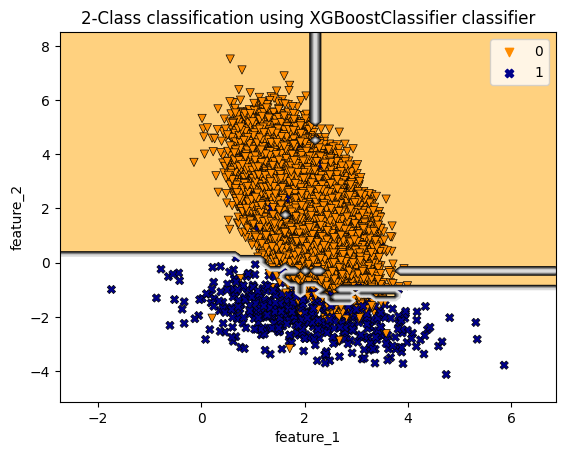

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      0.99      0.62      0.99      0.79      0.64      9851
    class 1       0.48      0.62      0.99      0.54      0.79      0.60       149

avg / total       0.99      0.98      0.63      0.99      0.79      0.64     10000



0.5422740524781342

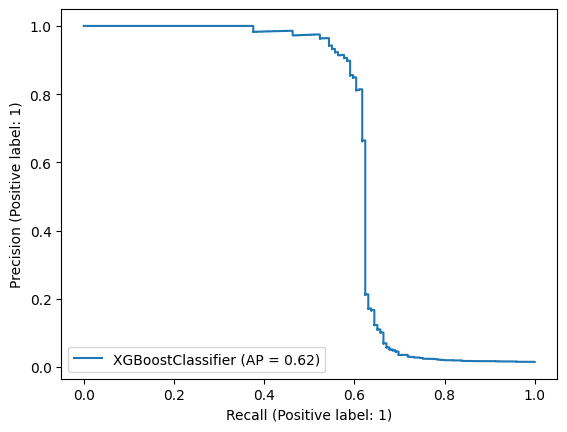

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay
from xgboost import XGBClassifier

RF_clf = XGBClassifier(scale_pos_weight=90, random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'XGBoostClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "XGBoostClassifier")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)     

# Decision Tree

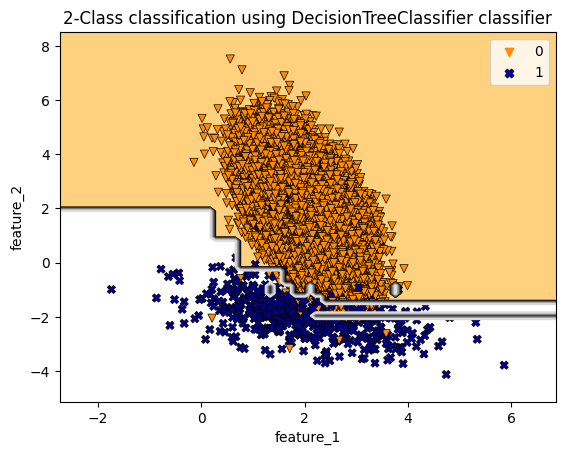

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.60      1.00      0.77      0.62      9851
    class 1       0.82      0.60      1.00      0.69      0.77      0.57       149

avg / total       0.99      0.99      0.60      0.99      0.77      0.62     10000



0.689922480620155

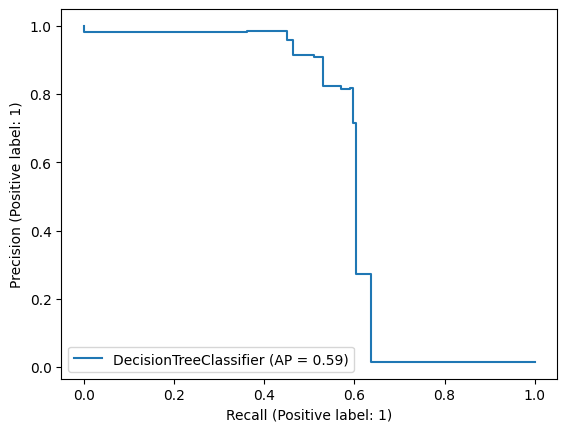

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay
from imblearn.metrics import classification_report_imbalanced

RF_clf = DecisionTreeClassifier(class_weight={0: 0.28684210526315784, 1: 0.7131578947368422}, random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'DecisionTreeClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "DecisionTreeClassifier")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)     

## metacost decision tree

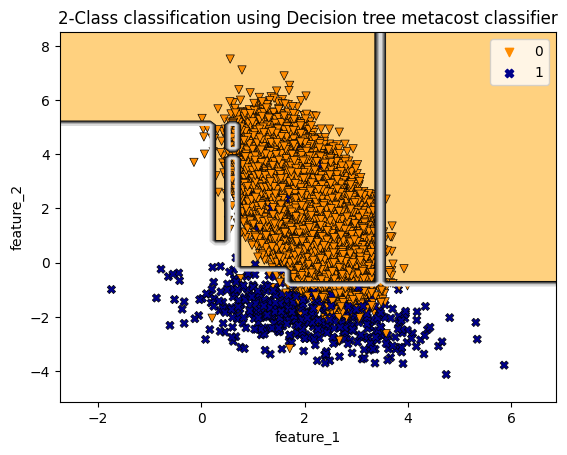

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.40      1.00      0.63      0.42      9851
    class 1       1.00      0.40      1.00      0.57      0.63      0.37       149

avg / total       0.99      0.99      0.40      0.99      0.63      0.42     10000



0.5562130177514791

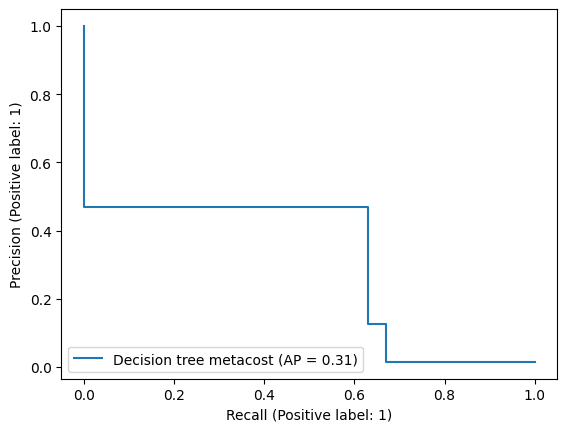

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from xgboost import XGBClassifier

C = np.array([[0, 100], [1, 0]])


decision_clf_MetaCost = MetaCost(DecisionTreeClassifier(random_state=0, max_depth=6), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X, y, decision_clf_MetaCost, 'Decision tree metacost')
plt.show()

PrecisionRecallDisplay.from_estimator(decision_clf_MetaCost, X_test, y_test, ax = plt.gca(), name = "Decision tree metacost")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)

# metacost XGBoost

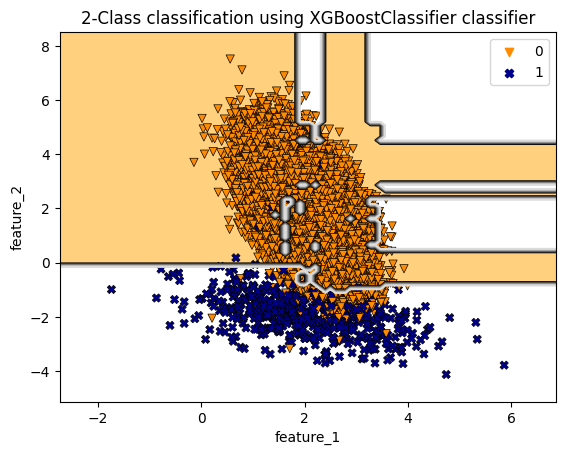

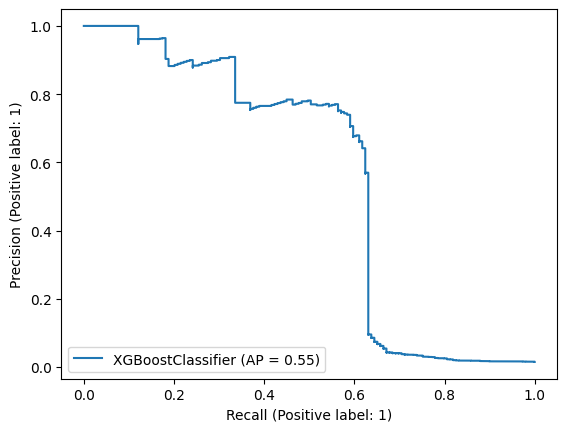

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from xgboost import XGBClassifier

C = np.array([[0, 100], [1, 0]])

xgb_clf_MetaCost = MetaCost(XGBClassifier(random_state=0), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X, y, xgb_clf_MetaCost, 'XGBoostClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(xgb_clf_MetaCost, X_test, y_test, ax = plt.gca(),name = "XGBoostClassifier")



In [ ]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, xgb_clf_MetaCost.predict(X_test), target_names=['class 0', 'class 1']))


compute_f1_score(xgb_clf_MetaCost, X_test, y_test)     

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      0.94      0.63      0.97      0.77      0.61      9851
    class 1       0.13      0.63      0.94      0.22      0.77      0.57       149

avg / total       0.98      0.93      0.64      0.95      0.77      0.61     10000



0.2209165687426557


# DecisionTreeClassifier with and without class weight + MetaCost implementation here 
## plot decision function and PR curves comparison


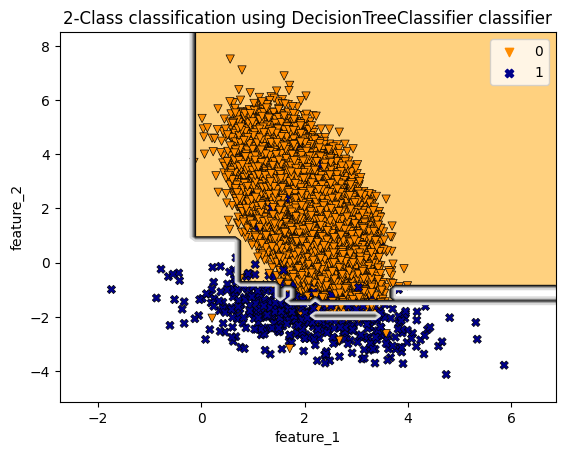

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.56      1.00      0.75      0.58      9851
    class 1       0.85      0.56      1.00      0.67      0.75      0.53       149

avg / total       0.99      0.99      0.56      0.99      0.75      0.58     10000



0.6720647773279351

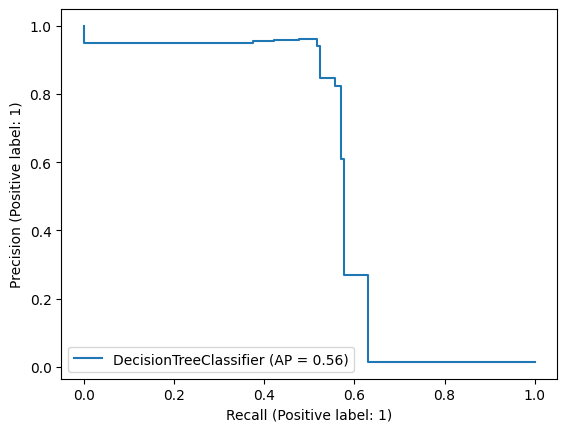

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay

dt_clf = DecisionTreeClassifier(random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X, y, dt_clf, 'DecisionTreeClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(dt_clf, X_test, y_test, ax = plt.gca(),name = "DecisionTreeClassifier")

print(classification_report_imbalanced(y_test, dt_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(dt_clf, X_test, y_test)     

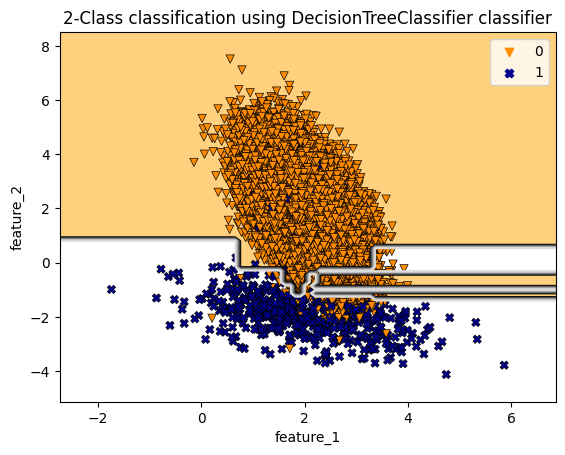

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.40      1.00      0.63      0.42      9851
    class 1       1.00      0.40      1.00      0.57      0.63      0.37       149

avg / total       0.99      0.99      0.40      0.99      0.63      0.42     10000



0.5562130177514791

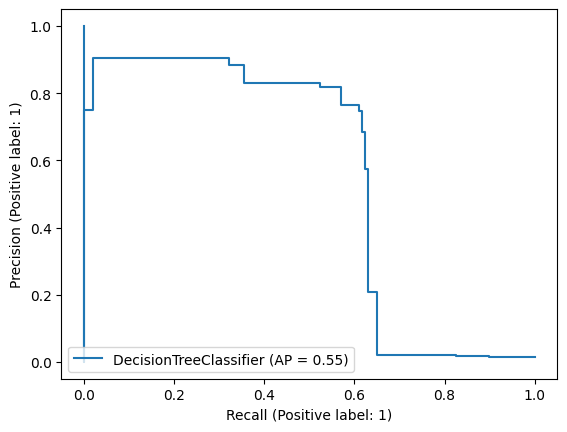

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay

RF_clf = DecisionTreeClassifier(class_weight="balanced", random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'DecisionTreeClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "DecisionTreeClassifier")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)     

# with tuned class_Weights

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Define the parameter grid
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in np.linspace(0.05, 0.95, 20)]}

# Instantiate the grid search model
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0, max_depth=6), param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'class_weight': {0: 0.28684210526315784, 1: 0.7131578947368422}}

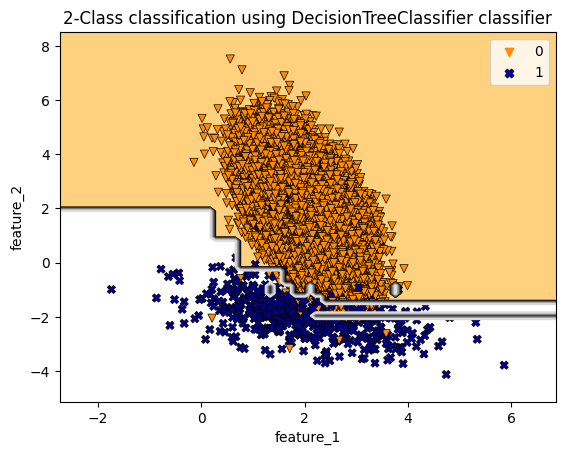

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.60      1.00      0.77      0.62      9851
    class 1       0.82      0.60      1.00      0.69      0.77      0.57       149

avg / total       0.99      0.99      0.60      0.99      0.77      0.62     10000



0.689922480620155

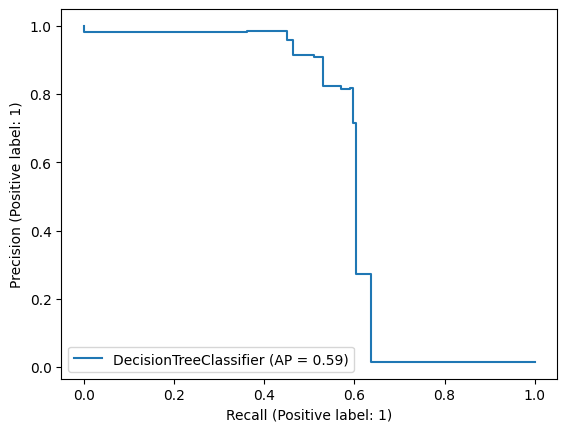

In [10]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay
from imblearn.metrics import classification_report_imbalanced

dt_clf_tuned = DecisionTreeClassifier(class_weight={0: 0.28684210526315784, 1: 0.7131578947368422}, random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X, y, dt_clf_tuned, 'DecisionTreeClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(dt_clf_tuned, X_test, y_test, ax = plt.gca(),name = "DecisionTreeClassifier")

print(classification_report_imbalanced(y_test, dt_clf_tuned.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(dt_clf_tuned, X_test, y_test)     

## metacost decision tree

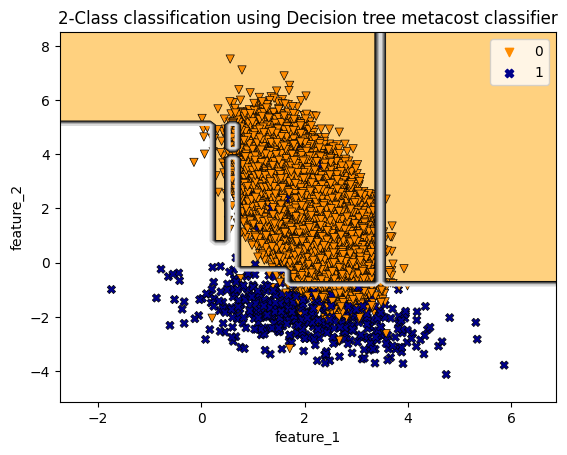

                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.99      1.00      0.40      1.00      0.63      0.42      9851
    class 1       1.00      0.40      1.00      0.57      0.63      0.37       149

avg / total       0.99      0.99      0.40      0.99      0.63      0.42     10000



0.5562130177514791

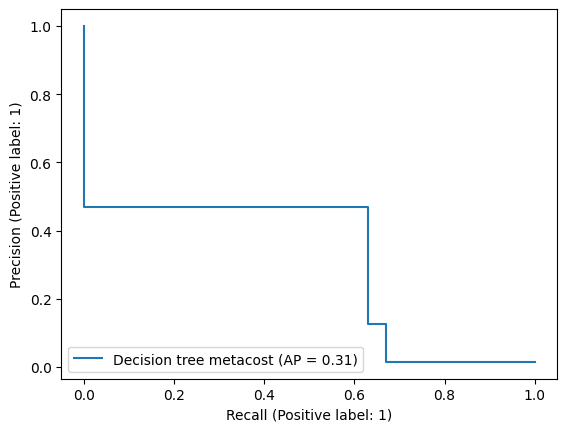

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from xgboost import XGBClassifier

C = np.array([[0, 100], [1, 0]])


decision_clf_MetaCost = MetaCost(DecisionTreeClassifier(random_state=0, max_depth=6), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X, y, decision_clf_MetaCost, 'Decision tree metacost')
plt.show()

PrecisionRecallDisplay.from_estimator(decision_clf_MetaCost, X_test, y_test, ax = plt.gca(), name = "Decision tree metacost")

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

compute_f1_score(RF_clf, X_test, y_test)

# Threshold adjustment

Adjust the threshold of previous models (without the "balanced" or "class_weight" versions) and get their F1 scores on test set. 

For threshold adjustment, we should create a separate small validation set from the original dataset.


In [ ]:
from sklearn.metrics import precision_recall_curve
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify=y_train)
print(Counter(y_val), Counter(y_tr))

Counter({0: 7881, 1: 119}) Counter({0: 31523, 1: 477})


LR Best Threshold on Validation=0.249077, F-Score=0.673
RF Best Threshold on Validation=0.380000, F-Score=0.634
XGBoost Best Threshold on Validation=0.364306, F-Score=0.639
Decision Tree Best Threshold on Validation=0.174603, F-Score=0.608
Weighted LR Best Threshold on Validation=0.842055, F-Score=0.667
Weighted RF Best Threshold on Validation=0.390000, F-Score=0.640
Weighted XGBoost Best Threshold on Validation=0.967420, F-Score=0.639
Weighted Decision Tree Best Threshold on Validation=0.964996, F-Score=0.641


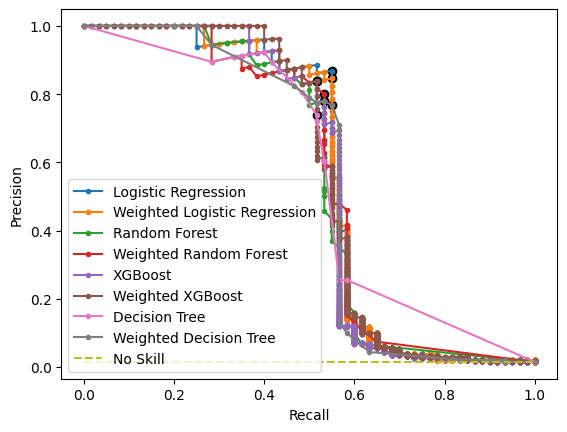

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0, stratify=y_train)

lr = LogisticRegression(random_state=0, max_iter=50)
lr.fit(X_tr, y_tr)
# predict probabilities
yhat = lr.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, LR_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Logistic Regression')
LR_fscore = (2 * precision * recall) / (precision + recall)
LR_ix = np.argmax(LR_fscore)
plt.scatter(recall[LR_ix], precision[LR_ix], marker='o', color='black')


lr_w = LogisticRegression(class_weight="balanced", random_state=0, max_iter=50)
lr_w.fit(X_tr, y_tr)
# predict probabilities
yhat = lr_w.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, LR_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted Logistic Regression')
LR_w_fscore = (2 * precision * recall) / (precision + recall)
LR_w_ix = np.argmax(LR_w_fscore)
plt.scatter(recall[LR_w_ix], precision[LR_w_ix], marker='o', color='black')


RF_clf = RandomForestClassifier(random_state=0)
RF_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = RF_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, RF_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Random Forest')
RF_fscore = (2 * precision * recall) / (precision + recall)
RF_ix = np.argmax(RF_fscore)
plt.scatter(recall[RF_ix], precision[RF_ix], marker='o', color='black')


RF_w_clf = RandomForestClassifier(class_weight="balanced", random_state=0)
RF_w_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = RF_w_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, RF_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted Random Forest')
RF_w_fscore = (2 * precision * recall) / (precision + recall)
RF_w_ix = np.argmax(RF_w_fscore)
plt.scatter(recall[RF_w_ix], precision[RF_w_ix], marker='o', color='black')


xgb_clf = XGBClassifier(random_state=0)
xgb_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = xgb_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, xgb_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='XGBoost')
xgb_fscore = (2 * precision * recall) / (precision + recall)
xgb_ix = np.argmax(xgb_fscore)
plt.scatter(recall[xgb_ix], precision[xgb_ix], marker='o', color='black')


xgb_w_clf = XGBClassifier(scale_pos_weight=99, random_state=0)
xgb_w_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = xgb_w_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, xgb_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted XGBoost')
xgb_w_fscore = (2 * precision * recall) / (precision + recall)
xgb_w_ix = np.argmax(xgb_w_fscore)
plt.scatter(recall[xgb_w_ix], precision[xgb_w_ix], marker='o', color='black')


DT_clf = DecisionTreeClassifier(random_state=0, max_depth=6)
DT_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = DT_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, DT_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Decision Tree')
DT_fscore = (2 * precision * recall) / (precision + recall)
DT_ix = np.argmax(DT_fscore)
plt.scatter(recall[DT_ix], precision[DT_ix], marker='o', color='black')


DT_w_clf = DecisionTreeClassifier(class_weight="balanced", random_state=0, max_depth=6)
DT_w_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = DT_w_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, DT_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted Decision Tree')
DT_w_fscore = (2 * precision * recall) / (precision + recall)
DT_w_ix = np.argmax(DT_w_fscore)
plt.scatter(recall[DT_w_ix], precision[DT_w_ix], marker='o', color='black')


print('LR Best Threshold on Validation=%f, F-Score=%.3f' % (LR_thresholds[LR_ix], LR_fscore[LR_ix]))
print('RF Best Threshold on Validation=%f, F-Score=%.3f' % (RF_thresholds[RF_ix], RF_fscore[RF_ix]))
print('XGBoost Best Threshold on Validation=%f, F-Score=%.3f' % (xgb_thresholds[xgb_ix], xgb_fscore[xgb_ix]))
print('Decision Tree Best Threshold on Validation=%f, F-Score=%.3f' % (DT_thresholds[DT_ix], DT_fscore[DT_ix]))

print('Weighted LR Best Threshold on Validation=%f, F-Score=%.3f' % (LR_w_thresholds[LR_w_ix], LR_w_fscore[LR_w_ix]))
print('Weighted RF Best Threshold on Validation=%f, F-Score=%.3f' % (RF_w_thresholds[RF_w_ix], RF_w_fscore[RF_w_ix]))
print('Weighted XGBoost Best Threshold on Validation=%f, F-Score=%.3f' % (xgb_w_thresholds[xgb_w_ix], xgb_w_fscore[xgb_w_ix]))
print('Weighted Decision Tree Best Threshold on Validation=%f, F-Score=%.3f' % (DT_w_thresholds[DT_w_ix], DT_w_fscore[DT_w_ix]))

# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')


# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()


# Plot a line chart of F1-score of all the models including threshold adjusted models. Name them appropriately so that it's easy to identify the models
 

## Threshold tuning

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
yhat = lr.predict_proba(X_test)
yhat = (yhat[:, 1]>LR_thresholds[LR_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
LR_fscore = (2 * precision * recall) / (precision + recall)

yhat = lr_w.predict_proba(X_test)
yhat = (yhat[:, 1]>LR_w_thresholds[LR_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
LR_w_fscore = (2 * precision * recall) / (precision + recall)

yhat = RF_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>RF_thresholds[RF_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
RF_fscore = (2 * precision * recall) / (precision + recall)

yhat = RF_w_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>RF_w_thresholds[RF_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
RF_w_fscore = (2 * precision * recall) / (precision + recall)

yhat = DT_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>DT_thresholds[DT_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
DT_fscore = (2 * precision * recall) / (precision + recall)

yhat = DT_w_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>DT_w_thresholds[DT_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
DT_w_fscore = (2 * precision * recall) / (precision + recall)

yhat = xgb_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>xgb_thresholds[xgb_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
xgb_fscore = (2 * precision * recall) / (precision + recall)

yhat = xgb_w_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>xgb_w_thresholds[xgb_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
xgb_w_fscore = (2 * precision * recall) / (precision + recall)

d = {'Model': ["Logistic Regression", "Weighted Logistic Regression", "Random Forest", "Weighted Random Forest",  "XGBoost", "Weighted XGBoost",  "Decision Tree", "Weighted Decision Tree"], 
      "Optimal Threshhold (Validation)": [LR_thresholds[LR_ix], LR_w_thresholds[LR_w_ix], RF_thresholds[RF_ix], RF_w_thresholds[RF_w_ix], xgb_thresholds[xgb_ix], xgb_w_thresholds[xgb_w_ix], DT_thresholds[DT_ix], DT_w_thresholds[DT_w_ix]] , 
      'Test F1 Score': [LR_fscore, LR_w_fscore, RF_fscore, RF_w_fscore, xgb_fscore, xgb_w_fscore, DT_fscore, DT_w_fscore]}

df = pd.DataFrame(data=d)

df.head(10)

,Model,Optimal Threshhold (Validation),Test F1 Score
0,Logistic Regression,0.249077,0.674510
1,Weighted Logistic Regression,0.842055,0.677165
2,Random Forest,0.380000,0.684825
3,Weighted Random Forest,0.390000,0.690196
4,XGBoost,0.364306,0.704453
5,Weighted XGBoost,0.967420,0.690196
6,Decision Tree,0.174603,0.669355
7,Weighted Decision Tree,0.964996,0.676580


## No Threshhold tuning

In [ ]:

lr = LogisticRegression(random_state=0, max_iter=50)
lr.fit(X_tr, y_tr)
lr_w = LogisticRegression(class_weight="balanced", random_state=0, max_iter=50)
lr_w.fit(X_tr, y_tr)
RF_clf = RandomForestClassifier(random_state=0)
RF_clf.fit(X_tr, y_tr)
RF_w_clf = RandomForestClassifier(class_weight="balanced", random_state=0)
RF_w_clf.fit(X_tr, y_tr)
xgb_clf = XGBClassifier(random_state=0)
xgb_clf.fit(X_tr, y_tr)
xgb_w_clf = XGBClassifier(scale_pos_weight=99, random_state=0)
xgb_w_clf.fit(X_tr, y_tr)
DT_clf = DecisionTreeClassifier(random_state=0)
DT_clf.fit(X_tr, y_tr)
DT_w_clf = DecisionTreeClassifier(class_weight="balanced", random_state=0)
DT_w_clf.fit(X_tr, y_tr)

LR_fscore = compute_f1_score(lr, X_test, y_test)
LR_w_fscore = compute_f1_score(lr_w, X_test, y_test)     
RF_fscore = compute_f1_score(RF_clf, X_test, y_test)
RF_w_fscore = compute_f1_score(RF_w_clf, X_test, y_test)
xgb_fscore = compute_f1_score(xgb_clf, X_test, y_test)
xgb_w_fscore = compute_f1_score(xgb_w_clf, X_test, y_test) 
DT_fscore = compute_f1_score(DT_clf, X_test, y_test)      
DT_w_fscore = compute_f1_score(DT_w_clf, X_test, y_test)   

In [ ]:
d2 = {'Model': ["Logistic Regression", "Weighted Logistic Regression", "Random Forest", "Weighted Random Forest",  "XGBoost", "Weighted XGBoost",  "Decision Tree", "Weighted Decision Tree"], 
      'Test F1 Score': [LR_fscore, LR_w_fscore, RF_fscore, RF_w_fscore, xgb_fscore, xgb_w_fscore, DT_fscore, DT_w_fscore]}

df2 = pd.DataFrame(data=d2)

df2.head(10)

,Model,Test F1 Score
0,Logistic Regression,0.567308
1,Weighted Logistic Regression,0.137885
2,Random Forest,0.680328
3,Weighted Random Forest,0.697095
4,XGBoost,0.710744
5,Weighted XGBoost,0.556886
6,Decision Tree,0.554054
7,Weighted Decision Tree,0.578571
